# Acknowledgement 

This tutorial was written by the course staffs of 10-707 Deep Learning at Cargenie Mellon University in Spring 2021.

They are: 
*   Instructor: Andrej Risteski
*   Education Associate: Fatima Jeffrey
*   Teaching Assistants: Amartya Basu, Bingbin Liu (leading author of this tutorial), Eagle Zhao, Tanya Marwah, George Cazenavette

(We made some updates.)

Additional references:
*   https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html
*   http://cs231n.stanford.edu/2019/syllabus.html




In [1]:
%matplotlib inline

## PyTorch Basics
### What is PyTorch?
It is a **replacement for NumPy** to use the power of GPUs, and a **deep learning research platform** that provides maximum flexibility and speed ([source](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)).

You can create a [PyTorch tensor](https://pytorch.org/docs/stable/tensors.html) in a similary way that you create a NumPy ndarray:

In [2]:
import numpy as np
import torch
print("torch version:", torch.__version__)

print('\nCreate a zero ndarray in NumPy:')
zero_np = np.zeros([2, 3])
print(zero_np)
print('\nCreate a zero tensor in PyTorch:')
zero_pt = torch.zeros([2,3])
print(zero_pt)

torch version: 1.10.0+cu111

Create a zero ndarray in NumPy:
[[0. 0. 0.]
 [0. 0. 0.]]

Create a zero tensor in PyTorch:
tensor([[0., 0., 0.],
        [0., 0., 0.]])


You can index into the tensor the same way you index a ndarray:

In [3]:
print("numpy: zero_np[0,1]: {}\t(type: {})".format(str(zero_np[0,1]), type(zero_np[0,1])))
print("torch: zero_pt[0,1]: {}\t(type: {} / shape: {})".format(str(zero_pt[0,1]), type(zero_pt[0,1]), zero_pt[0,1].shape))
# Use "item()" to get a Python number from a single-valued tensor.
print("       zero_pt[0,1].item(): {}\t(type: {})".format(zero_pt[0,1].item(), type(zero_pt[0,1].item())))

numpy: zero_np[0,1]: 0.0	(type: <class 'numpy.float64'>)
torch: zero_pt[0,1]: tensor(0.)	(type: <class 'torch.Tensor'> / shape: torch.Size([]))
       zero_pt[0,1].item(): 0.0	(type: <class 'float'>)


You can change the datatype of a tensor similarly to changing the type of a ndarray:

In [4]:
print("zero_np (default):", zero_np.dtype)
zero_np = zero_np.astype(int)
print("zero_np (coerced):", zero_np.dtype)

print('')

print("zero_pt (default):", zero_pt.dtype)
zero_pt = zero_pt.type(torch.LongTensor)
print("zero_pt (coerced):", zero_pt.dtype)
zero_pt = zero_pt.type(torch.DoubleTensor)
print("zero_pt (coerced):", zero_pt.dtype)

zero_np (default): float64
zero_np (coerced): int64

zero_pt (default): torch.float32
zero_pt (coerced): torch.int64
zero_pt (coerced): torch.float64


In [5]:
torch.get_default_dtype()

torch.float32

Notice the difference in the default dtype for numpy vs torch: numpy defaults to float64 whereas torch defaults to float32. This may be a source of discrepancy if your calculations require high precision.

A ndarray can be turned into a tensor, and vice versa:

In [6]:
print('Turn a ndarray into a tensor with "torch.tensor()":')
zero_pt_from_np = torch.tensor(zero_np)
print(zero_pt_from_np)
print('or "torch.from_numpy():"')
zero_pt_from_np = torch.from_numpy(zero_np)
print(zero_pt_from_np)

print('\nTurn a tensor into ndarray with ".numpy()":')
zero_np_from_pt = zero_pt.numpy()
print(zero_np_from_pt)
print(type(zero_np_from_pt))

Turn a ndarray into a tensor with "torch.tensor()":
tensor([[0, 0, 0],
        [0, 0, 0]])
or "torch.from_numpy():"
tensor([[0, 0, 0],
        [0, 0, 0]])

Turn a tensor into ndarray with ".numpy()":
[[0. 0. 0.]
 [0. 0. 0.]]
<class 'numpy.ndarray'>


The design of PyTorch allows it to better utilize GPUs. Upon creation, a PyTorch tensor resides on the CPU. You can move a tensor across devices using `.to()`:

In [7]:
t = torch.randn(2)
print("Initial device:\t'{}'".format(t.device))

Initial device:	'cpu'


In [8]:
t = t.to('cuda:0')
print("Move to gpu:\t'{}'".format(t.device))

Move to gpu:	'cuda:0'


In [9]:
t = t.to('cpu')
print("Back to cpu:\t'{}'".format(t.device))
# Why bother?
t.numpy()

Back to cpu:	'cpu'


array([-0.75410867,  1.788922  ], dtype=float32)

In [10]:
# What would happen if you do the following:
t.to('cuda').numpy()

TypeError: ignored


Training an MNIST Classifier
=====
## Custom Dataset, Model Checkpointing, and Fine-tune

In [11]:
import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import glob
import os
import numpy as np
from PIL import Image

## 1. Custom Dataset
PyTorch has many built-in datasets such as MNIST and CIFAR. In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class. Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset.

To prepare the data for training, please upload the downloaded images to a folder named `Colab/data/mnist_png` in your google drive.
An example of the file path is `Colab/data/mnist_png/training/0/1.png`.
You only need the classes for digits 0 and 1, and don't need to upload all images since it's gonna take a while.

If you are on a terminal, you can run these commands:

`wget https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true`

`mv mnist_png.tar.gz?raw=true mnist_png.tar.gz`

`tar -xzf mnist_png.tar.gz`

Mounting data files from Google drive

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Uncomment the following commands to download the data

In [ ]:
# !mkdir -p "/content/drive/My Drive/Colab/data/"

In [ ]:
# !wget https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true

--2022-02-23 22:47:14--  https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz [following]
--2022-02-23 22:47:15--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2022-02-23 22:47:15--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting 

In [ ]:
# mv mnist_png.tar.gz?raw=true "/content/drive/My Drive/Colab/data/mnist_png.tar.gz"

In [ ]:
# !tar -xzf "/content/drive/My Drive/Colab/data/mnist_png.tar.gz" --directory "/content/drive/My Drive/Colab/data/"

In [13]:
!ls "/content/drive/My Drive/Colab/data/mnist_png/"

testing  training


In [14]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    To make it faster, we only make a binary classifier between digit 0 and 1.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(2):
            filenames = glob.glob(os.path.join(root, str(i), '*.png'))
            print("Class {:d}: {:d} samples.".format(i, len(filenames)))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()
            self.labels.append(label)

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [15]:
# This step may be very slow

# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]

folder_root = '/content/drive/My Drive/Colab/data/'
trainset = MNIST(
    root=os.path.join(folder_root, 'mnist_png/training'),
    preload=True, transform=transforms.ToTensor(),
)

# Use the torch dataloader to iterate through the dataset
# We want the dataset to be shuffled during training.
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# Load the testset
testset = MNIST(
    root=os.path.join(folder_root, 'mnist_png/testing'),
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
# We do not need to shuffle the test data.
testset_loader = DataLoader(testset, batch_size=20, shuffle=False, num_workers=1)

Class 0: 520 samples.
Class 1: 436 samples.
Class 0: 980 samples.
Class 1: 1135 samples.


In [16]:
print(len(trainset)) # len = 60000 for full mnist; currently smaller
print(len(testset))  # len = 10000 for full mnist; currently smaller

956
2115


### Visualize the dataset

tensor(1) tensor(0) tensor(0) tensor(1) tensor(0) tensor(0) tensor(0) tensor(0)
tensor(0) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0) tensor(0) tensor(1)


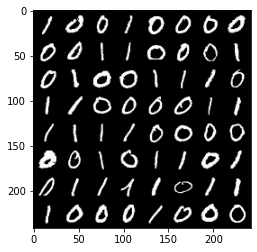

In [17]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(8)))
print(' '.join('%5s' % labels[j] for j in range(8, 16)))

In [18]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Define a Conv Net

Pytorch's [Conv2d page](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) has the formula for calculating the output size, given the input size, kernel size, stride, and padding.

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #        dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.max_pool = nn.MaxPool2d(2)
        # ReLU(inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Note: the following two ways for max pooling / relu are equivalent.
        # 1) with torch.nn.functional:
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # 2) with torch.nn:
        x = self.relu(self.max_pool(self.conv2_drop(self.conv2(x))))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


### Train the network

In [20]:
from time import time
def train(model, optimizer, trainset_loader, epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            # bring data to the computing device, e.g. GPU
            data, target = data.to(device), target.to(device)

            # forward pass
            output = model(data)
            # compute loss: negative log-likelihood
            loss = F.nll_loss(output, target)
            
            # backward pass
            # clear the gradients of all tensors being optimized.
            optimizer.zero_grad()
            # accumulate (i.e. add) the gradients from this forward pass
            loss.backward()
            # performs a single optimization step (parameter update)
            optimizer.step()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
            
        end = time()
        print('{:.2f}s'.format(end-start))
        test() # evaluate at the end of epoch
    return model

In [21]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [22]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = train(model, optimizer, trainset_loader, 10)  # train 10 epochs should get you to an almonst perfect accuracy

Train Epoch: 0 [0/956 (0%)]	Loss: 2.307127
0.41s


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2561, Accuracy: 14/2115 (1%)

0.20s

Test set: Average loss: 2.1198, Accuracy: 2054/2115 (97%)

0.22s

Test set: Average loss: 1.8503, Accuracy: 982/2115 (46%)

0.20s

Test set: Average loss: 1.2146, Accuracy: 980/2115 (46%)

0.21s

Test set: Average loss: 0.5822, Accuracy: 1525/2115 (72%)

0.21s

Test set: Average loss: 0.3058, Accuracy: 2106/2115 (100%)

Train Epoch: 6 [640/956 (67%)]	Loss: 0.190063
0.22s

Test set: Average loss: 0.1644, Accuracy: 2106/2115 (100%)

0.21s

Test set: Average loss: 0.0905, Accuracy: 2107/2115 (100%)

0.21s

Test set: Average loss: 0.0573, Accuracy: 2108/2115 (100%)

0.21s

Test set: Average loss: 0.0409, Accuracy: 2106/2115 (100%)



## 2. Save the model (model checkpointing)

Now we have trained a model, let's see how we can save it to a checkpoint.
We care about checkpointing mainly for two reasons: 1) we do not want to retrain the model everytime we want to use it; 2) we want to be able to resume quickly if training gets interrupted.

For example, if your training takes long, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened, or you simply want to test models at different training iterations.
This is particularly relevant to Colab, since you may get disconnected due to e.g. inactivity or exceeding the maximum session time (12 hours).

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk.

In [23]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(ckpt_path, model, optimizer):
    state = torch.load(ckpt_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % ckpt_path)

In [24]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2452, Accuracy: 980/2115 (46%)



### Define a training loop with model checkpointing

In [27]:
ckpt_root = '/content/drive/My Drive/Colab/ckpt/'

Uncomment the following command to create the checkpoint folder

In [ ]:
# !mkdir "{ckpt_root}"

In [28]:
def train_save(model, epoch, save_interval, log_interval=100):

    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint(os.path.join(ckpt_root, 'mnist-%i.pth' % iteration), model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    model_save_path = os.path.join(ckpt_root, 'mnist-%i.pth' % iteration)
    save_checkpoint(model_save_path, model, optimizer)
    return model_save_path

In [29]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model_save_path = train_save(model, epoch=10, save_interval=500, log_interval=100)

Train Epoch: 0 [0/956 (0%)]	Loss: 2.412032


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.3628, Accuracy: 0/2115 (0%)


Test set: Average loss: 2.2626, Accuracy: 931/2115 (44%)


Test set: Average loss: 2.1419, Accuracy: 980/2115 (46%)


Test set: Average loss: 1.9569, Accuracy: 980/2115 (46%)


Test set: Average loss: 1.5537, Accuracy: 980/2115 (46%)


Test set: Average loss: 0.8851, Accuracy: 980/2115 (46%)

Train Epoch: 6 [640/956 (67%)]	Loss: 0.501545

Test set: Average loss: 0.4556, Accuracy: 2103/2115 (99%)


Test set: Average loss: 0.2803, Accuracy: 2105/2115 (100%)


Test set: Average loss: 0.1570, Accuracy: 2108/2115 (100%)


Test set: Average loss: 0.0932, Accuracy: 2108/2115 (100%)

model saved to /content/drive/My Drive/Colab/ckpt/mnist-150.pth


In [30]:
model_save_path

'/content/drive/My Drive/Colab/ckpt/mnist-150.pth'

In [31]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint(model_save_path, model, optimizer)
# should give you the final model accuracy
test()

model loaded from /content/drive/My Drive/Colab/ckpt/mnist-150.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0932, Accuracy: 2108/2115 (100%)



## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [32]:
# What's in a state dict?
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [33]:
checkpoint = torch.load(model_save_path)
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        # only load the conv layers
        states_to_load[name] = param
print("Number of parameter variables to load:", len(states_to_load))

# Construct a new state_dict in which the layers we want
# to import from the checkpoint is updated with the parameters
# from the checkpoint
model = Net().to(device)
model_state = model.state_dict()
print("Number of parameter variables in the model:", len(model_state))
model_state.update(states_to_load)
        
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Number of parameter variables to load: 4
Number of parameter variables in the model: 8


In [34]:
test() # without fine-tuning.

model = train(model, optimizer, trainset_loader, 2)  # training 1 epoch will get you to >95%
# As a comparison, training from scratch for 2 epoch gets about <60% test accuracy.

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.4300, Accuracy: 0/2115 (0%)

Train Epoch: 0 [0/956 (0%)]	Loss: 2.625304
0.22s

Test set: Average loss: 0.9948, Accuracy: 980/2115 (46%)

0.21s

Test set: Average loss: 0.3445, Accuracy: 2074/2115 (98%)



### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model. The "load_checkpoint" function we saw earlier uses "load_state_dict", which requires all parameters to match exactly (both the naming and the actual weights).
Sometimes we may want to load a model partially even when not all parameters match perfectly; for example, when you only care about the convolution part of a model but not the final fully connected layer. The following function allows to do this.

In [35]:
def load_checkpoint_tolerate(ckpt_path, model):
  """
  The argument specitifications are the same as "load_checkpoint".
  """
  if ckpt_path and os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path)
    loaded_sd = ckpt['state_dict']
    loaded_opt = ckpt['optimizer']
    try:
      model.load_state_dict(loaded_sd)
    except:
      curr_params = model.state_dict()
      curr_keys = list(curr_params.keys())

      updated_params = {}
      for k,v in loaded_sd.items():
        if k in curr_keys and loaded_sd[k].shape==curr_params[k].shape:
          updated_params[k] = v
        else:
          print('Failed to load:', k)
    curr_params.update(updated_params)
    model.load_state_dict(curr_params)

For example, the following is a different model than Net defined above:

In [36]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        # same conv layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # fewer FC layers
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
load_checkpoint_tolerate(os.path.join(ckpt_root, "mnist-150.pth"), model)

Failed to load: fc1.weight
Failed to load: fc1.bias
Failed to load: fc2.weight
Failed to load: fc2.bias


Question: can you answer why these parameters "failed to load"?

In [38]:
model = train(model, optimizer, trainset_loader, 1)  # training 1 epoch will get you to >95%

Train Epoch: 0 [0/956 (0%)]	Loss: 1.893768
0.21s


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2514, Accuracy: 2043/2115 (97%)



### Clean up your code with nn.Sequential

In [39]:
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()

        # conv layers: feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        # fc layers: classifier
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)


In [40]:
model = NetSeq().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = train(model, optimizer, trainset_loader, 10)

Train Epoch: 0 [0/956 (0%)]	Loss: 2.416133
0.22s


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2546, Accuracy: 980/2115 (46%)

0.22s

Test set: Average loss: 1.9601, Accuracy: 980/2115 (46%)

0.22s

Test set: Average loss: 1.3060, Accuracy: 980/2115 (46%)

0.20s

Test set: Average loss: 0.7559, Accuracy: 980/2115 (46%)

0.21s

Test set: Average loss: 0.5943, Accuracy: 1801/2115 (85%)

0.21s

Test set: Average loss: 0.5075, Accuracy: 2105/2115 (100%)

Train Epoch: 6 [640/956 (67%)]	Loss: 0.478848
0.22s

Test set: Average loss: 0.3862, Accuracy: 2105/2115 (100%)

0.21s

Test set: Average loss: 0.2634, Accuracy: 2111/2115 (100%)

0.21s

Test set: Average loss: 0.1489, Accuracy: 2107/2115 (100%)

0.21s

Test set: Average loss: 0.0883, Accuracy: 2106/2115 (100%)



# Example: pretrained AlexNet from Pytorch model zoo

In [41]:
# https://pytorch.org/vision/stable/models.html
import torchvision.models as models
alexnet_rand = models.alexnet(pretrained=False).to('cuda')
alexnet_pretrained = models.alexnet(pretrained=True).to('cuda')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

We can compare the filters in the first conv layer.

In [42]:
from math import ceil, sqrt
import pdb

def show_net_weights(model, weight_name, scale=1, trim_scale=4):
    weight = model[weight_name]
    weight = weight.cpu().numpy()
    weight = weight.transpose(0,2,3,1)

    grid = visualize_grid(weight, padding=1, scale=scale, trim_scale=trim_scale)
    grid = grid.astype('uint8')
    # pdb.set_trace()
    plt.imshow(grid)

def visualize_grid(Xs, ubound=255.0, padding=1, scale=1, trim_scale=1):
    (N, H, W, C) = Xs.shape
    print(Xs.shape)
    print("X: max={:f} / min={:f} / mean={:f} / std={:f}".format(Xs.max(), Xs.min(), Xs.mean(), Xs.std()))
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    low, high = np.min(Xs), np.max(Xs)
    trim = trim_scale*np.std(Xs)
    mean = np.mean(Xs)
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                img -= mean
                img = np.minimum(img, trim)
                img = np.maximum(img, -trim)
                img = ubound * (img + trim) * scale
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

(64, 11, 11, 3)
X: max=0.052477 / min=-0.052486 / mean=0.000368 / std=0.030092


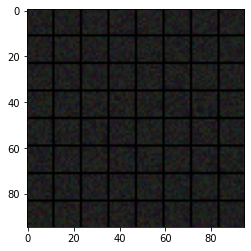

In [43]:
alexnet_rand = models.alexnet(pretrained=False).to('cuda')
show_net_weights(alexnet_rand.state_dict(), weight_name='features.0.weight')

(64, 11, 11, 3)
X: max=0.935403 / min=-0.781915 / mean=-0.000079 / std=0.116981


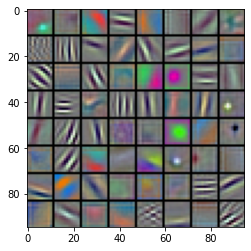

In [44]:
alexnet_pretrained = models.alexnet(pretrained=True).to('cuda')
show_net_weights(alexnet_pretrained.state_dict(), weight_name='features.0.weight')